In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import time

import PulseFinderScipy as pf
import PulseQuantities as pq
import PulseClassification as pc

In [2]:
# set plotting style
mpl.rcParams['font.size']=10
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]

# ==================================================================
# define DAQ and other parameters
#wsize = 12500             # size of event window in samples. 1 sample = 2 ns.
event_window = 25.  # in us
wsize = int(500 * event_window)  # samples per waveform # 12500 for 25 us
vscale = (2000.0/16384.0) # = 0.122 mV/ADCC, vertical scale
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale

post_trigger = 0.5 # Was 0.2 for data before 11/22/19
trigger_time_us = event_window*(1-post_trigger)
trigger_time = int(trigger_time_us/tscale)

n_sipms = 8
n_channels = n_sipms+1 # includes sum

# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)

# sphe sizes in mV*sample
chA_spe_size = 29.02
chB_spe_size = 30.61
chC_spe_size = 28.87
chD_spe_size = 28.86*1.25 # scale factor (0.7-1.4) empirical as of Dec 9, 2020
chE_spe_size = 30.4
chF_spe_size = 30.44
chG_spe_size = 30.84
chH_spe_size = 30.3*1.8 # scale factor (1.6-2.2) empirical as of Dec 9, 2020
spe_sizes = [chA_spe_size, chB_spe_size, chC_spe_size, chD_spe_size, chE_spe_size, chF_spe_size, chG_spe_size, chH_spe_size]

**load in raw data**

In [3]:
#data_dir="../data/bkg_3.5g_3.9c_27mV_7_postrecover2_5min/"
#data_dir="../data/bkg_3.5g_3.9c_27mV_1_5min/"
#data_dir="../data/fewevts/"
#data_dir="../data/po_5min/"
#data_dir = "C:/Users/ryanm/Documents/Research/Data/bkg_3.5g_3.9c_27mV_6_postrecover_5min/" # Old data
#data_dir = "C:/Users/swkra/Desktop/Jupyter temp/data-201909/091219/"
#data_dir = "/home/xaber/caen/wavedump-3.8.2/data/011521/Flow_Th_Co57_4.8g_5.0c_25mV_1.5bar_circ_5min/"
data_dir = "/Volumes/GoogleDrive/.shortcut-targets-by-id/11qeqHWCbcKfFYFQgvytKem8rulQCTpj8/crystalize/data/data-202102/022321/Po_6.8g_7.0c_3mV_1.75bar_circ_20min/"
#data_dir  = "C:/Users/ryanm/Documents/Research/Data/bkg_2.8g_3.2c_25mV_1_1.6_circ_0.16bottle_5min/" # Weird but workable data
#data_dir = "C:/Users/ryanm/Documents/Research/Data/Flow_Th_with_Ba133_0g_0c_25mV_1.5bar_nocirc_5min/" # Weird double s1 data
#"C:/Users/swkra/Desktop/Jupyter temp/data-202009/091720/bkg_3.5g_3.9c_27mV_7_postrecover2_5min/"

t_start = time.time()

max_evts = 20000#5000  # 25000 # -1 means read in all entries; 25000 is roughly the max allowed in memory on the DAQ computer
max_pts = -1  # do not change
if max_evts > 0:
    max_pts = wsize * max_evts
load_dtype = "int16"
ch_data = []
for ch_ind in range(n_sipms):
    ch_data.append(np.fromfile(data_dir + "wave"+str(ch_ind)+".dat", dtype=load_dtype, count=max_pts))

t_end_load = time.time()
print("Time to load files: ", t_end_load-t_start)

Time to load files:  19.61836004257202


**scale waveforms to get units of mV/sample then for each channel ensure we have an integer number of events**

In [4]:
array_dtype = "float32" # using float32 reduces memory for big files, otherwise implicitly converts to float64

# matrix of all channels including the sum waveform
v_matrix_all_ch = []
for ch_ind in range(n_sipms):
    V = vscale * ch_data[ch_ind].astype(array_dtype) / spe_sizes[ch_ind]
    V = V[:int(len(V) / wsize) * wsize]
    V = V.reshape(int(V.size / wsize), wsize) # reshape to make each channel's matrix of events
    v_matrix_all_ch.append(V)
    if ch_ind==0: v_sum = np.copy(V)
    else: v_sum += V
v_matrix_all_ch.append(v_sum)


# create a time axis in units of µs:
x = np.arange(0, wsize, 1)
t = tscale*x
t_matrix = np.repeat(t[np.newaxis,:], V.size/wsize, 0)

# Note: if max_evts != -1, we won't load in all events in the dataset
n_events = int(v_matrix_all_ch[0].shape[0])
    
# perform baseline subtraction:
# for now, using first 2 µs of event
baseline_start = int(0./tscale)
baseline_end = int(2./tscale)

# baseline subtracted (bls) waveforms saved in this matrix:
v_bls_matrix_all_ch = np.zeros( np.shape(v_matrix_all_ch), dtype=array_dtype) # dims are (chan #, evt #, sample #)

t_end_wfm_fill = time.time()
print("Time to fill all waveform arrays: ", t_end_wfm_fill - t_end_load)

print("Events to process: ",n_events)
for i in range(0, n_events):
    
    sum_baseline = np.mean( v_matrix_all_ch[-1][i,baseline_start:baseline_end] ) #avg ~us, avoiding trigger
    baselines = [ np.mean( ch_j[i,baseline_start:baseline_end] ) for ch_j in v_matrix_all_ch ]
    
    sum_data = v_matrix_all_ch[-1][i,:] - sum_baseline
    ch_data = [ch_j[i,:]-baseline_j for (ch_j,baseline_j) in zip(v_matrix_all_ch,baselines)]
    
    v_bls_matrix_all_ch[:,i,:] = ch_data

Time to fill all waveform arrays:  190.35780215263367
Events to process:  20000


**now setup for pulse finding on the baseline-subtracted sum waveform**

In [5]:
# max number of pulses per event
max_pulses = 4

# pulse RQs to save

# RQs to add:
# Pulse level: channel areas (fracs; max fracs), TBA, rise time? (just difference of AFTs...)
# Event level: drift time; S1, S2 area
# Pulse class (S1, S2, other)

p_start = np.zeros(( n_events, max_pulses), dtype=np.int)
p_end   = np.zeros(( n_events, max_pulses), dtype=np.int)
p_found = np.zeros(( n_events, max_pulses), dtype=np.int)

p_area = np.zeros(( n_events, max_pulses))
p_max_height = np.zeros(( n_events, max_pulses))
p_min_height = np.zeros(( n_events, max_pulses))
p_width = np.zeros(( n_events, max_pulses))

p_afs_2l = np.zeros((n_events, max_pulses) )
p_afs_2r = np.zeros((n_events, max_pulses) )
p_afs_1 = np.zeros((n_events, max_pulses) )
p_afs_25 = np.zeros((n_events, max_pulses) )
p_afs_50 = np.zeros((n_events, max_pulses) )
p_afs_75 = np.zeros((n_events, max_pulses) )
p_afs_99 = np.zeros((n_events, max_pulses) )
            
p_hfs_10l = np.zeros((n_events, max_pulses) )
p_hfs_50l = np.zeros((n_events, max_pulses) )
p_hfs_10r = np.zeros((n_events, max_pulses) )
p_hfs_50r = np.zeros((n_events, max_pulses) )

p_mean_time = np.zeros((n_events, max_pulses) )
p_rms_time = np.zeros((n_events, max_pulses) )

# Channel level (per event, per pulse, per channel)
p_start_ch = np.zeros((n_events, max_pulses, n_channels-1), dtype=np.int)
p_end_ch = np.zeros((n_events, max_pulses, n_channels-1), dtype=np.int )
p_area_ch = np.zeros((n_events, max_pulses, n_channels-1) )
p_area_ch_frac = np.zeros((n_events, max_pulses, n_channels-1) )

p_area_top = np.zeros((n_events, max_pulses))
p_area_bottom = np.zeros((n_events, max_pulses))
p_tba = np.zeros((n_events, max_pulses))

p_class = np.zeros((n_events, max_pulses), dtype=np.int)

# Event-level variables
n_pulses = np.zeros(n_events, dtype=np.int)

n_s1 = np.zeros(n_events, dtype=np.int)
n_s2 = np.zeros(n_events, dtype=np.int)
sum_s1_area = np.zeros(n_events)
sum_s2_area = np.zeros(n_events)
drift_Time = np.zeros(n_events)
s1_before_s2 = np.zeros(n_events)

# Temporary, for testing low area, multiple-S1 events
dt = np.zeros(n_events)
small_weird_areas = np.zeros(n_events)
big_weird_areas = np.zeros(n_events)

print("Running pulse finder on {:d} events...".format(n_events))

Running pulse finder on 20000 events...


In [6]:
# use for coloring pulses
pulse_class_colors = np.array(['blue', 'green', 'red', 'magenta', 'darkorange'])
pulse_class_labels = np.array(['Other', 'S1-like LXe', 'S1-like gas', 'S2-like', 'Merged S1/S2'])
pc_legend_handles=[]
for class_ind in range(len(pulse_class_labels)):
    pc_legend_handles.append(mpl.patches.Patch(color=pulse_class_colors[class_ind], label=str(class_ind)+": "+pulse_class_labels[class_ind]))

n_golden = int(0)

for i in range(0, n_events):
    if i%500==0: print("Event #",i)
    
    # Find pulse locations; other quantities for pf tuning/debugging
    start_times, end_times, peaks, data_conv, properties = pf.findPulses( v_bls_matrix_all_ch[-1,i,:], max_pulses )


    # Sort pulses by start times, not areas
    startinds = np.argsort(start_times)
    n_pulses[i] = len(start_times)
    #if (n_pulses[i] < 1):
        #print("No pulses found for event {0}; skipping".format(i))
        #continue
    for m in startinds:
        if m >= max_pulses:
            continue
        p_start[i,m] = start_times[m]
        p_end[i,m] = end_times[m]



    # Individual channel pulse locations, in case you want this info
    # Can't just ":" the the first index in data, findPulses doesn't like it, so have to loop 
    #for j in range(n_channels-1):
    #    start_times_ch, end_times_ch, peaks_ch, data_conv_ch, properties_ch = pf.findPulses( v_bls_matrix_all_ch[j,i,:], max_pulses )
        # Sorting by start times from the sum of channels, not each individual channel
    #    for k in startinds:
    #        if k >= len(start_times_ch):
    #            continue
    #        p_start_ch[i,k,j] = start_times_ch[k]
    #        p_end_ch[i,k,j] = end_times_ch[k]
        

    # Calculate interesting quantities, only for pulses that were found
    for pp in range(n_pulses[i]):

        # Area, max & min heights, width, pulse mean & rms
        p_area[i,pp] = pq.GetPulseArea(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:] )
        p_max_height[i,pp] = pq.GetPulseMaxHeight(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:] )
        p_min_height[i,pp] = pq.GetPulseMinHeight(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:] )
        p_width[i,pp] = p_end[i,pp] - p_start[i,pp]
        #(p_mean_time[i,pp], p_rms_time[i,pp]) = pq.GetPulseMeanAndRMS(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:])

        # Area and height fractions      
        (p_afs_2l[i,pp], p_afs_1[i,pp], p_afs_25[i,pp], p_afs_50[i,pp], p_afs_75[i,pp], p_afs_99[i,pp]) = pq.GetAreaFraction(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:] )
        (p_hfs_10l[i,pp], p_hfs_50l[i,pp], p_hfs_10r[i,pp], p_hfs_50r[i,pp]) = pq.GetHeightFractionSamples(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[-1,i,:] )
    
        # Areas for individual channels and top bottom
        p_area_ch[i,pp,:] = pq.GetPulseAreaChannel(p_start[i,pp], p_end[i,pp], v_bls_matrix_all_ch[:,i,:] )
        p_area_ch_frac[i,pp,:] = p_area_ch[i,pp,:]/p_area[i,pp]
        p_area_top[i,pp] = sum(p_area_ch[i,pp,top_channels])
        p_area_bottom[i,pp] = sum(p_area_ch[i,pp,bottom_channels])
        p_tba[i, pp] = (p_area_top[i, pp] - p_area_bottom[i, pp]) / (p_area_top[i, pp] + p_area_bottom[i, pp])

        
    # Pulse classifier, work in progress
    p_class[i,:] = pc.ClassifyPulses(p_tba[i, :], (p_afs_50[i, :]-p_afs_2l[i, :])*tscale, n_pulses[i])

    # Event level analysis. Look at events with both S1 and S2.
    index_s1 = (p_class[i,:] == 1) + (p_class[i,:] == 2) # S1's
    index_s2 = (p_class[i,:] == 3) + (p_class[i,:] == 4) # S2's
    n_s1[i] = np.sum(index_s1)
    n_s2[i] = np.sum(index_s2)
    
    if n_s1[i] > 0:
        sum_s1_area[i] = sum(p_area[i, index_s1])
    if n_s2[i] > 0:
        sum_s2_area[i] = sum(p_area[i, index_s2])
    if n_s1[i] == 1:
        if n_s2[i] == 1:
            drift_Time[i] = tscale*(p_start[i, np.argmax(index_s2)] - p_start[i, np.argmax(index_s1)])
        if n_s2[i] > 1:
            s1_before_s2[i] = np.argmax(index_s1) < np.argmax(index_s2) 
    
    if drift_Time[i]>0:
        n_golden += 1

Event # 0
Event # 500
Event # 1000
Event # 1500
Event # 2000
Event # 2500
Event # 3000
Event # 3500
Event # 4000
Event # 4500
Event # 5000
Event # 5500
Event # 6000
Event # 6500
Event # 7000
Event # 7500
Event # 8000
Event # 8500
Event # 9000
Event # 9500
Event # 10000
Event # 10500
Event # 11000
Event # 11500
Event # 12000
Event # 12500
Event # 13000
Event # 13500
Event # 14000
Event # 14500
Event # 15000
Event # 15500
Event # 16000
Event # 16500
Event # 17000
Event # 17500
Event # 18000
Event # 18500
Event # 19000
Event # 19500


**Define some standard cuts for plotting**

In [14]:
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden,n_golden*100./n_events))

p_t_rise = tscale*(p_afs_50-p_afs_2l)

# Define some standard cuts for plotting
cut_dict = {}
cut_dict['ValidPulse'] = p_area > 0
cut_dict['PulseClass0'] = p_class == 0
cut_dict['S1'] = (p_class == 1) + (p_class == 2)
cut_dict['S2'] = (p_class == 3) + (p_class == 4)
cut_dict['Co_peak'] = (p_area>30)*(p_area<60)
SS_cut = drift_Time > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=True # One entry per pulse
save_S1S2_plots=True # One entry per S1 (S2) pulse
save_event_plots=True # One entry per event
pulse_cut_name = 'ValidPulse'#'Co_peak'
pulse_cut = cut_dict[pulse_cut_name]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut),np.sum(pulse_cut)*100./np.size(p_area)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

cleanArea = p_area[pulse_cut].flatten()
cleanMax = p_max_height[pulse_cut].flatten()
cleanMin = p_min_height[pulse_cut].flatten()
cleanWidth = p_width[pulse_cut].flatten()
cleanPulseClass = p_class[pulse_cut].flatten()

cleanAFS2l = p_afs_2l[pulse_cut].flatten()
cleanAFS50 = p_afs_50[pulse_cut].flatten()
cleanRiseTime = p_t_rise[pulse_cut].flatten()

cleanAreaCh = p_area_ch[pulse_cut] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac = p_area_ch_frac[pulse_cut]
cleanAreaTop = p_area_top[pulse_cut].flatten()
cleanAreaBottom = p_area_bottom[pulse_cut].flatten()
cleanTBA = p_tba[pulse_cut].flatten()
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

s1_cut = pulse_cut*cut_dict['S1']
cleanS1Area = p_area[s1_cut].flatten()
cleanS1RiseTime = p_t_rise[s1_cut].flatten()
cleanS1AreaChFrac = p_area_ch_frac[s1_cut]
cleanS1TBA = p_tba[s1_cut].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut),np.sum(s1_cut)*100./np.size(p_area)))

s2_cut = pulse_cut*cut_dict['S2']
cleanS2Area = p_area[s2_cut].flatten()
cleanS2RiseTime = p_t_rise[s2_cut].flatten()
cleanS2AreaChFrac = p_area_ch_frac[s2_cut]
cleanS2TBA = p_tba[s2_cut].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut),np.sum(s2_cut)*100./np.size(p_area)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany = n_pulses < 1000 # How many pulses you do want
nArea = p_area[howMany,:]
nMax = p_max_height[howMany,:]
nmin = p_min_height[howMany,:]
nWidth = p_width[howMany,:]

na2l = p_afs_2l[howMany]
na50 = p_afs_50[howMany]


# Event level quantities 
event_cut_dict = {}
event_cut_dict["SS"] = drift_Time > 0 
event_cut_dict["MS"] = (n_s1 == 1)*(n_s2 > 1)*s1_before_s2
event_cut_dict["Po"] = (drift_Time>0)*np.any((p_tba<-0.25)*(p_tba>-0.75)*(p_area>1500)*(p_area<3200), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["lg_S1"] = (drift_Time>0)*np.any((p_area>1000.)*cut_dict["S1"], axis=1) # true if any S1 has area>1000

event_cut_name = "SS"#"lg_S1"
event_cut = event_cut_dict[event_cut_name] 
cleanSumS1 = sum_s1_area[event_cut]
cleanSumS2 = sum_s2_area[event_cut]
cleanDT = drift_Time[event_cut]
print("number of events found passing cut "+event_cut_name+" = {0:d} ({1:g}%)".format(np.sum(event_cut),np.sum(event_cut)*100./n_events))


t_end_recon = time.time()
print('time to reconstruct: ', t_end_recon - t_end_wfm_fill)

number of golden events found = 488 (2.44%)
number of pulses found passing cut ValidPulse = 6073 (7.59125% of pulses found)
number of S1 pulses found = 3060 (3.825% of pulses found)
number of S2 pulses found = 3013 (3.76625% of pulses found)
number of events found passing cut SS = 488 (2.44%)
time to reconstruct:  471.8050878047943



**Make plots of interesting pulse quantities**

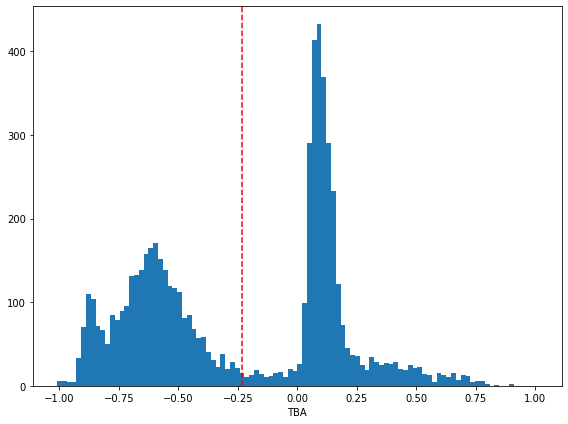

In [9]:
# Plots of all pulses combined (after cuts)
pl.figure()
pl.hist(cleanTBA, bins=100, range=(-1.01, 1.01))
pl.axvline(x=np.mean(cleanTBA), ls='--', color='r')
pl.xlabel("TBA")
if save_pulse_plots: pl.savefig(data_dir+"TBA_"+pulse_cut_name+".png")
#pl.show() 

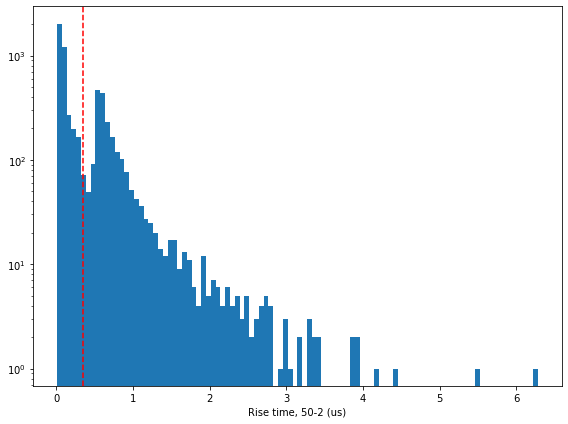

In [10]:
pl.figure()
pl.yscale("log")
pl.hist(cleanRiseTime, 100)
pl.axvline(x=np.mean(cleanRiseTime), ls='--', color='r')
pl.xlabel("Rise time, 50-2 (us)")
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_"+pulse_cut_name+".png")
#pl.show()

In [ ]:
pl.figure()
#pl.yscale("log")
pl.hist(np.log10(cleanArea), 100)
pl.axvline(x=np.mean(np.log10(cleanArea)), ls='--', color='r')
pl.xlabel("log10 Pulse area (phd)")
if save_pulse_plots: pl.savefig(data_dir+"log10PulseArea_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
#pl.yscale("log")
area_max_plot=150
pl.hist(cleanArea, bins=125,range=(0,area_max_plot))
if np.mean(cleanArea)<area_max_plot: pl.axvline(x=np.mean(cleanArea), ls='--', color='r')
pl.xlabel("Pulse area (phd)")
if save_pulse_plots: pl.savefig(data_dir+"PulseArea_Under150phd"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.yscale("log")
pl.hist(cleanPulseClass )
pl.legend(handles=pc_legend_handles)
pl.xlabel("Pulse Class")
if save_pulse_plots: pl.savefig(data_dir+"PulseClass_"+pulse_cut_name+".png")

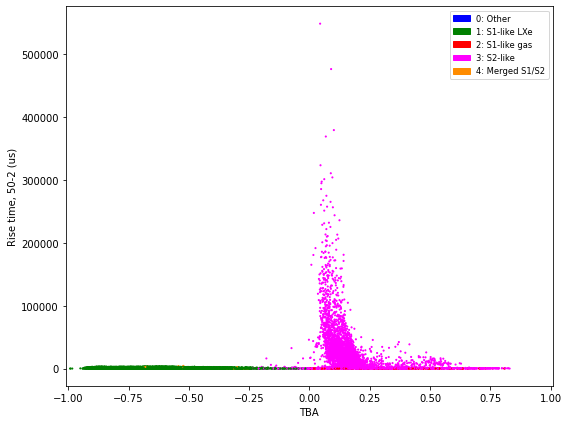

In [12]:
pl.figure()
pl.scatter(cleanTBA, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(-0.05,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_TBA_"+pulse_cut_name+".png")

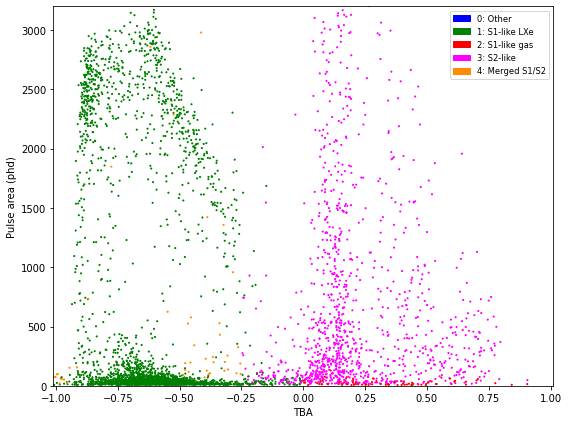

In [11]:
pl.figure()
pl.scatter(cleanTBA, cleanArea, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(-1.01,1.01)
pl.ylim(0, 3200)
pl.ylabel("Pulse area (phd)")
pl.xlabel("TBA")
pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Pulse area_vs_TBA_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.xscale("log")
pl.scatter(cleanArea, cleanRiseTime, s = 1.2, c = pulse_class_colors[cleanPulseClass])
pl.xlim(5,10**6)
pl.ylim(-0.05,4)
pl.ylabel("Rise time, 50-2 (us)")
pl.xlabel("Pulse area (phd)")
pl.legend(handles=pc_legend_handles)
#pl.xlim(0.7*min(p_area.flatten()), 1.5*max(p_area.flatten()))
if save_pulse_plots: pl.savefig(data_dir+"RiseTime_vs_PulseArea_"+pulse_cut_name+".png")

In [ ]:
# Channel fractional area for all pulses
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanAreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanAreaChFrac[:,j]), ls='--', color='r')
    #print("ch {0} area frac mean: {1}".format(j,np.mean(cleanAreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("Pulse area fraction")
    pl.title('Ch '+str(j))
if save_pulse_plots: pl.savefig(data_dir+"pulse_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
# Plots of all S1 or all S2 pulses
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanS1AreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanS1AreaChFrac[:,j]), ls='--', color='r')
    #print("S1 ch {0} area frac mean: {1}".format(j,np.mean(cleanS1AreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("S1 area fraction")
    pl.title('Ch '+str(j))
if save_S1S2_plots: pl.savefig(data_dir+"S1_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
for j in range(0, n_channels-1):
    pl.subplot(4,2,j+1)
    pl.hist(cleanS2AreaChFrac[:,j],bins=100,range=(0,1))
    pl.axvline(x=np.mean(cleanS2AreaChFrac[:,j]), ls='--', color='r')
    #print("S2 ch {0} area frac mean: {1}".format(j,np.mean(cleanS2AreaChFrac[:,j])))
    #pl.yscale('log')
    pl.xlabel("S2 area fraction")
    pl.title('Ch '+str(j))
if save_S1S2_plots: pl.savefig(data_dir+"S2_ch_area_frac_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(cleanS1TBA, bins=100, range=(-1.01,1.01) )
pl.axvline(x=np.mean(cleanS1TBA), ls='--', color='r')
pl.xlabel("S1 TBA")
if save_S1S2_plots: pl.savefig(data_dir+"S1TBA_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(cleanS2TBA, bins=100, range=(-1.01,1.01) )
pl.axvline(x=np.mean(cleanS2TBA), ls='--', color='r')
pl.xlabel("S2 TBA")
if save_S1S2_plots: pl.savefig(data_dir+"S2TBA_"+pulse_cut_name+".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanS1Area), 100)
pl.axvline(x=np.mean(np.log10(cleanS1Area)), ls='--', color='r')
pl.xlabel("log10 S1 area")
if save_S1S2_plots: pl.savefig(data_dir+"log10_S1_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanS2Area), 100)
pl.axvline(x=np.mean(np.log10(cleanS2Area)), ls='--', color='r')
pl.xlabel("log10 S2 area")
if save_S1S2_plots: pl.savefig(data_dir+"log10_S2_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(cleanS1Area, bins=125)
pl.axvline(x=np.mean(cleanS1Area), ls='--', color='r')
pl.xlabel("S1 area (phd)")
if save_S1S2_plots: pl.savefig(data_dir+"S1_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(cleanS2Area, 500)
pl.axvline(x=np.mean(cleanS2Area), ls='--', color='r')
pl.xlabel("S2 area (phd)")
if save_S1S2_plots: pl.savefig(data_dir+"S2_"+pulse_cut_name +".png")

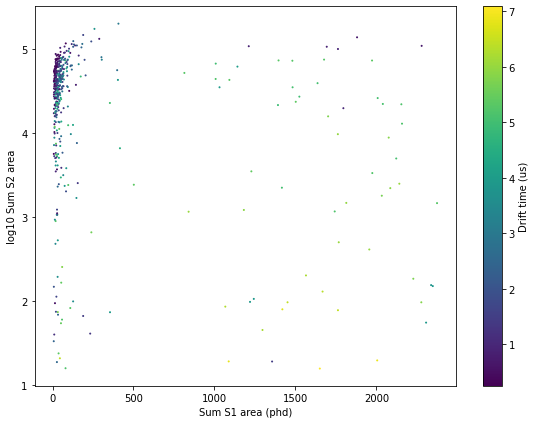

In [15]:
# Plots of event-level variables
pl.figure()
pl.scatter(cleanSumS1, np.log10(cleanSumS2), s = 1, c=cleanDT)
pl.xlabel("Sum S1 area (phd)")
pl.ylabel("log10 Sum S2 area")
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_vs_SumS1_"+event_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanSumS1), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS1)), ls='--', color='r')
pl.xlabel("log10 Sum S1 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS1_"+event_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanSumS2), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS2)), ls='--', color='r')
pl.xlabel("log10 Sum S2 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_"+event_cut_name +".png")

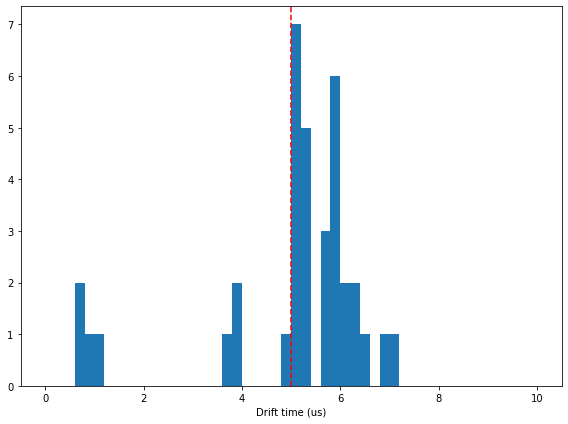

In [12]:
pl.figure() # Only ever plot this for SS events?
pl.hist(cleanDT, bins=50, range=(0,10))
pl.axvline(x=np.mean(cleanDT), ls='--', color='r')
pl.xlabel("Drift time (us)")
if save_event_plots: pl.savefig(data_dir+"DriftTime_"+event_cut_name +".png")

In [ ]:
pl.figure() # Only ever plot this for SS events?
pl.scatter(cleanDT, cleanSumS2)
pl.xlabel("Drift time (us)")
pl.ylabel("Sum S2 area")
# Calculate mean vs drift bin
drift_bins=np.linspace(0,13,50)
drift_ind=np.digitize(cleanDT, bins=drift_bins)
s2_medians=np.zeros(np.shape(drift_bins))
s2_std_err=np.ones(np.shape(drift_bins))*0#10000
for i_bin in range(len(drift_bins)):
    found_i_bin = np.where(drift_ind==i_bin)
    s2_area_i_bin = cleanSumS2[found_i_bin]
    if len(s2_area_i_bin) < 1: continue
    s2_medians[i_bin]=np.median(s2_area_i_bin) # Median instead of mean, better at ignoring outliers
    s2_std_err[i_bin]=np.std(s2_area_i_bin)/np.sqrt(len(s2_area_i_bin))
pl.errorbar(drift_bins, s2_medians, yerr=s2_std_err, linewidth=3, elinewidth=3, capsize=5, capthick=4, color='red')
pl.ylim(bottom=0)
if save_event_plots: pl.savefig(data_dir+"SumS2_vs_DriftTime_"+event_cut_name +".png")